# Л6: Использование Inference API для работы с моделями ИИ (Часть 2)

**Inference API** - это сервис, который обеспечивает быстрый доступ к многочисленным предобученным моделями ИИ, размещенным на инфраструктуре HuggingFace. Используя его нет необходимости в загрузке модели и запуску модели локально. Таким образом можно создавать прототипы приложений для решения различных задач не переживая о вычислительных мощностях своего компьютера. 

**Inference API** предоставляет бесплатный и мгновенный доступ к популярным и эффективным моделями для решения следующего спектра задача:
* Генерация текста: включает большие языковые модели и подсказки для вызова инструментов, генерируйте и экспериментируйте с высококачественными ответами.
* Генерация изображений: легко создавайте персонализированные изображения.
* Работа с документами.
* Классические задачи ИИ: готовые к использованию модели для классификации текста, изображений, распознавания речи и многого другого.


**В этой работе мы познакомимся с этим инструментом и в качестве примера создадим собственного умного ассистента для написания программного кода.**

## 1/ Подготовка среды выполнения
На данной этапе вам наобходимо подготовить виртуальное окружение и установить все необходимые библиотеки.

1. Создать и активировать (или только активировать, если ранне создавали) виртуальной окружение `python`.

В терминале вводим следующие команды команды:

*создаем виртуальное окружение с помощью `python-venv`*
```
python -m venv env
```
*активируем виртуальное окружение*
```
env\Scripts\activate
```
**Примечание.** `env` - это название вашего виртуального окружения, назвать его можете как угодно.

После этого можем выбрать наш локальный интерпрететор pyhton, нажав на кнопку выше "Select kernel".

2. Устанавливаем все необходимые библиотеки

**Примечание.** Библиотеки установятся внутрь вашего виртуального окружения.

Нам понадобятся библиотеки Diffusers, Transformers, Accelerate.

```
pip install transformers
```
Также для работы вышеперечисленных бибилиотек потребуется PyTorch:
```
pip install torch
```
Библиотека Gradio для создания web-приложения.
```
pip install gradio
```
Также для работы с изображение нам потребуется библиотека PIL (Python Image Library) `Pillow`
```
pip install Pillow
```

## 2/ Начало рабты. Создание Inference Client

Для бессерверного обращение к модели (то есть без запуска ее на своем каком-то сервере или локально) необходимо отправить запрос, используя Inference API. В результате этого запроса мы получим ответ - Inference (то есть вывод модели). Запрос можно формировать разынми способами, но в этой работе предлагается использовать Python библиотеку `huggingface_hub`. Выполните установку
```
pip install --upgrade huggingface_hub
```

Эта библиотека предоставляет модуль `InferenceClient`, с помощью которого создадим клиент, который будет формировать запрос на сервера Hugging Face. Импортируем этот модуль. Также импортируете Gradio.

In [ ]:
from huggingface_hub import InferenceClient
import gradio as gr

Есть одно НО! Для использования Serverless Inference API необходимо иметь **токен доступа**. Чтобы его получить необходимо зарегистрироваться на сайте Hugging Face, затем перейдите на [странице создания токенов](https://huggingface.co/settings/tokens/new?globalPermissions=inference.serverless.write&tokenType=fineGrained). Создайте `fine-grained` токен с областью действия `Make calls to the serverless Inference API`.

***Примечание***. Не распространяйте свой токен в публичных местах, иначе он будет скопрометирован и Hugging Face его удалит! Токен можно скопировать только один раз в моменте его создания. Сохраните его где-нибудь лично у себя и используете только в коде своего приложения когда необходимо.

Вставьте сюда сгенерированный токен.

In [ ]:
hf_token = "hf_******************"

Для создания умного ассистента, с которым можно поговорить о том о сем будем использовать модель Image-Text-to-Text генерации текста `meta-llama/Llama-3.2-11B-Vision-Instruct`. Это мультимодальная модель, способная рабоать как текстом, так и с изображениями

In [ ]:
ai_model = "meta-llama/Llama-3.2-11B-Vision-Instruct"

Создадим клиента через класс `InferenceClient`, указав ему используемую модель и свой токен доступа:

In [ ]:
client = InferenceClient(model=ai_model, token=hf_token)

## 3/ Тестирование работы модели в режиме чата (`chat completion`)
В прошлой работе мы использовали объект `client` для формирования запроса к модели ИИ и с его помщью встпуали в чат с моделью. Мы интересовались у нее про столицу государства.
```python
msgs = [{"role": "user", "content": "What is the capital of Great Britan?"}]
```
Теперь изменим наше сообщение. Передадим изображение какого-нибудь города и попросим выяснить, что это за город и какая страна. Например, передадим изображением города Вена. 

In [ ]:
msgs = [] # массив для хранения диалога

В связи с тем, что нашее сообшение содержит теперь графические элементы, изменится структура сообщения

In [ ]:
message = {
    "role": "user", 
    "content": [
        {
            "type": "text",
            "text": "Which city and from which country is shown in the picture?"
        },
        {
            "type": "image_url",
            "image_url": {
                "url": "https://avatars.mds.yandex.net/i?id=107f48d281098e173fd94c4ec00bb756_l-4504543-images-thumbs&n=13"
            }
        }
    ]
}

Внесем первое сообщение в диалог:

In [ ]:
msgs.append(message)

Передаем через клиента наш запрос. Также указываем максимальный размер ответного соощения `max_tokens`

In [ ]:
ans = client.chat_completion(messages=msgs, max_tokens=100, stream=False)

Выведем, что нам ответила модель ИИ. В ответ мы получаем json формат. Вот так вытаскивем само сообщение:

In [ ]:
print(ans.choices[0].message.content)

Вот [здесь](https://huggingface.co/docs/api-inference/tasks/chat-completion) можно почитать подробнее про организацию чата с ИИ и структуру ответов

Для дальнейшей работы необходимо сохранять историю переписки. Поэтому все сообщения (наши и модели) складываем в `msgs` по порядку. Обязательно указываем роли: Роль и контент сообщения от ИИ мы можем вытащить из структуры ответа `ans`

In [ ]:
msgs.append({"role": ans.choices[0].message.role, "content": ans.choices[0].message.content})

Вот получается такая история переписки:

In [ ]:
msgs

Теперь отправим наше следующее сообщение, чтобы поддержвать разговор. Поинтересуемся, какие главные достопримечательности можно посетить. Впишем в наш диалог `msgs` сообщение, но уже в более простой форме, потому что у нас текстовое сообщение

In [ ]:
msgs.append({"role": "user", "content": "What are the main attractions to visit in this city?"})

Продолжаем разговор:

In [ ]:
ans = client.chat_completion(messages=msgs, max_tokens=200, stream=False)
print(ans.choices[0].message.content)

И также сохраняем ответ в историю переписки

In [ ]:
msgs.append({"role": ans.choices[0].message.role, "content": ans.choices[0].message.content})

### Задание ✅

Проведите небольшой диалог в таком формате с моделью ИИ. Попросите у модели распознать объекты и тест на изображении

## 4/ Генерация изображений (`text_to_image`)

Через Inference API можно запускать различные модели ИИ, в том числе для генерации изображений. Создадим новый клиент для работы с моделью `stabilityai/stable-diffusion-3-medium-diffusers`


In [ ]:
image_model = "stabilityai/stable-diffusion-3-medium-diffusers"

In [ ]:
img_client = InferenceClient(image_model)

Вы можете попросить сгенерировать модель изображение, переда ей какой-нибудь промт. Для мы теперь используем метод `text_to_image`. Например, попросим ИИ создать изображение в стиле Айвазовского. Промпт будет следующий:

In [ ]:
prompt="Create an image of a sea wave in the style of Aivazovsky's paintings"

Отправим запрос модели. Как видим, время ожидания ответа модели на порядок меньше по сравнению с локально запушенной моделью в одной из предыдущих ЛР

In [ ]:
out = img_client.text_to_image(prompt=prompt)

Посмотрим на ответ. Модель возвращает изображение в формате PIL

In [ ]:
out

## 5/ Создание WEB-интерфейса с помощью `Gradio`

Создайте приложение Gradio в формате чата с помощью блока `gr.ChatInterface`. Так как мы планируем использовать чат не только для текста, но и для изображений, блок необходимо сделать мультмодальным, передав параметр `multimodal=True` 

Ему необходимо указать функцию обработки сообщений, в которую вы поместите обращение клиента к модели ИИ как это было выше. Функция принимает на вход два параметра
* `message` - текущее сообщение, текст
* `history` - история сообщений с чат-ботом, список из словарей, с указанием ролей

Например, пусть это будет функция с названием chatbot
```python
def chatbot(message, history):
    ...
```


Для примера ниже приведен код "пустышка". При вводе сообщения попробуйте вставить изображение (можно выбрать на диске или вставить скопированное). `print(message)` покаже вам структуру сообщения. Как можете увидеть, в сообщение дается ссылка на локальное расположение файла изображения. **Но мы не можем передать модели ИИ ссылку на локальный файл, у нее просто не будет доступа к ней!**

In [ ]:
import gradio as gr

def echo(message, history):
    print(message)
    return "echo"

demo = gr.ChatInterface(
    fn=echo, 
    type="messages", 
    title="Chat with LLM",
    multimodal=True
)
demo.launch()

### Решение
1. Включить данные изображения в строку URL и получить Data URI. На изображение ниже показана структура такой ссылки:

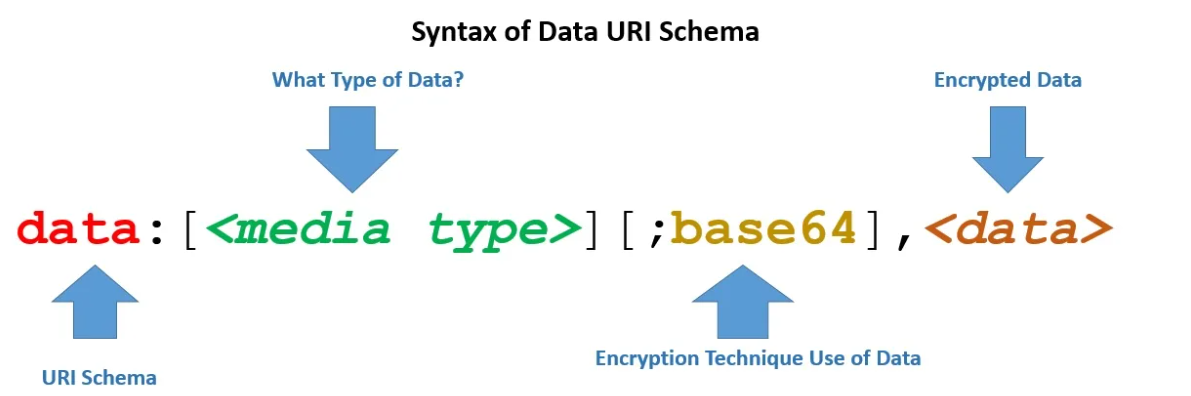

### `base64`
Двоичные данные файла изображения кодируются в `base64`, в результате получается строка. Например, если мы берем изображение формата `.png`, то получим вот такой Data URI:

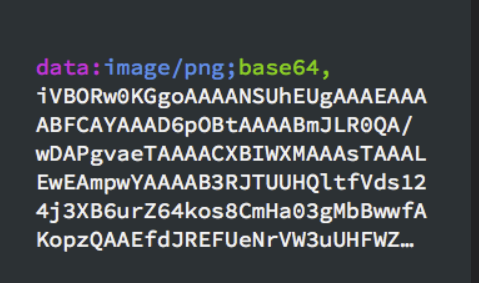

Для работы с кодировкой `base64` в Python есть соответствующая библиотека
```python
import base64
```

## Форма отчетности
В качестве отчета по лабораторной работе вам необходимо предоставить:
1. Файл с кодом вашего приложения (Python Script или Jupyter Nonebook)
2. Скриншот работы графического web-интерфейса вашего приложения

Отчет разместить на [Google диске](https://drive.google.com/drive/folders/1xhGVF935teSij4CIjEqy2XFADXUUBYRc?usp=sharing). 

Найдите папку вашей подгруппы, в ней создайте папку с вашей фамилией. Именно там вы будете помещать все отчеты по лабораторным занятиям. Для отчета по данной работе создайте папку с именем "ЛР1" и поместите туда ваш отчет.